In [1]:
## Import needed mods
import numpy as np, pandas as pd, os, glob
import vcfpy as vcf, hypermutatorqtl as hqtl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set MAT locus
MAT = hqtl.MAT

## Bring in centromere paths
Centromeres = hqtl.Centromeres

## View path
Centromeres.head()

,0,1
0,970169,1006931
1,835384,889427
2,1370568,1409632
3,708804,752337
4,1559983,1587231


In [3]:
## Set vcf paths
vcfpath = '/home/croth/H99_VCF/Bt65F1prog-Chr_*-H99_latest_Vikas_assembly-28.vcf.gz'

## Sort paths
vcfs = sorted(glob.glob(vcfpath))

## CHeck that paths exists
for p in vcfs:
    assert os.path.exists(p), "%s does not exist."%(p)

## print number of vcf
len(vcfs)

14

In [4]:
## Use the vcf.Reader to bring the file into python
recsc = []
for vf in vcfs:
    rdr = vcf.Reader.from_path(vf)
    recs_c = np.array([rec for rec in rdr])
    recsc.append(recs_c)
    
## For the records in the VCF file
recs = np.concatenate(recsc)
#np.array([rec for rec in rdr if rec.QUAL > 0])

## Delete memory hogs
del recsc

## Gather sample names from 1st record
rec0 = recs[0] 
samples = [s.sample for s in rec0]

## print number of recs and number of sampels
len(recs), len(samples)

(300172, 28)

In [5]:
## Gather the genotypes from
## each record for each sample
gts = []
for rec in recs:
    loci = []
    for s in rec:
        gt = s.data['GT']
        if gt is None:
            loci.append(np.nan)
        else:
            loci.append(float(gt))
    gts.append(loci)

In [6]:
## Gather the dpeth from
## each record for each sample
dps = []
for rec in recs:
    sdps = []
    
    for s in rec:
        
        if s.called:
            sdps.append(int(s.data['DP']))
        else:
            sdps.append(np.nan)
    
    dps.append(sdps)

In [7]:
## Gather the allelic read depth from
## each record for each samples
adps = []
for rec in recs:
    sadps = []
    
    for s in rec:
        
        if s.called:
            
            ads = np.array(s.data['AD'])
            gt = int(s.data['GT'])
            k = float(ads[gt])/(np.sum(ads)+1)
        
            sadps.append(k)
        else:
            sadps.append(np.nan)
    
    adps.append(sadps)

In [8]:
## Gather other needed info per record
POS = [rec.POS for rec in recs]
CONTIG = [rec.CHROM for rec in recs]
DP = [rec.INFO['DP'] for rec in recs]
REF = [rec.REF for rec in recs]
ALTTYPE = [rec.ALT[0].type for rec in recs]
ALT = [rec.ALT[0].value for rec in recs]
ALTLEN = [len(a) for a in ALT]
NALT = [len(rec.ALT) for rec in recs]

## Calculate the minimum depth
DPmin = []
for rec in recs:
    if not None in [s.called for s in rec]:
        dpmin = np.min([int(s.data['DP']) for s in rec])
    else:
        dpmin = np.nan
    DPmin.append(dpmin)
    
## Gather quality scores, and log10 qscore
quals = [rec.QUAL for rec in recs]
qualt = np.log10(np.array(quals)+1)

In [9]:
## Make Depth dataframe
DPS = pd.DataFrame(dps)
DPS.columns = samples
DPS['Pos'] = POS
DPS['Contig'] = CONTIG
DPS['DPmin'] = DPmin
DPS['Alt'] = ALT
DPS['Ref'] = REF
DPS['Type'] = ALTTYPE
DPS['Altlen'] = ALTLEN
DPS['Qual'] = qualt
DPS['NALT'] = NALT

In [10]:
## Make Allelic depth dataframe
ADPS = pd.DataFrame(adps)
ADPS.columns = samples
ADPS['Pos'] = POS
ADPS['Contig'] = CONTIG
ADPS['DPmin'] = DPmin
ADPS['Alt'] = ALT
ADPS['Ref'] = REF
ADPS['Type'] = ALTTYPE
ADPS['Altlen'] = ALTLEN
ADPS['Qual'] = qualt
ADPS['NALT'] = NALT

In [11]:
## Make genotype dataframe
GTS = pd.DataFrame(gts)
GTS.columns = samples
GTS['Pos'] = POS
GTS['Contig'] = CONTIG
GTS['DPmin'] = DPmin
GTS['Alt'] = ALT
GTS['Ref'] = REF
GTS['Type'] = ALTTYPE
GTS['Altlen'] = ALTLEN
GTS['Qual'] = qualt
GTS['NALT'] = NALT

In [12]:
## MAke a chromosome length, midpont dataframe
clens = pd.DataFrame([(a.id,int(a.length)) for a in rdr.header.lines[4:18]])
clens.columns = ['Contig','Pos']
clens.index = [int(c.split('_')[-1]) for c in clens.Contig ]
clens = clens.T[sorted(clens.index.tolist())].T
clens['Cumsum'] = [0] + list(np.cumsum(clens.Pos.values[:-1]))
clens['Midpts'] = clens.Pos.values/2 + clens.Cumsum.values

## Save chromosome lengths
clens.to_csv('../DATA/Clens.csv.gz')

## Set chromosome list
chrlist = clens.Contig.values

## View head
clens.head()

,Contig,Pos,Cumsum,Midpts
1,Chr_1,2291717,0,1.14586e+06
2,Chr_2,1618389,2291717,3.10091e+06
3,Chr_3,1575141,3910106,4.69768e+06
4,Chr_4,1084216,5485247,6.02736e+06
5,Chr_5,1821986,6569463,7.48046e+06


In [13]:
## Take biallelic sites
GTS = GTS[(GTS.NALT==1)]

## Calcualte allele freq
GTS['AF'] = GTS[samples].sum(axis=1)/len(samples)

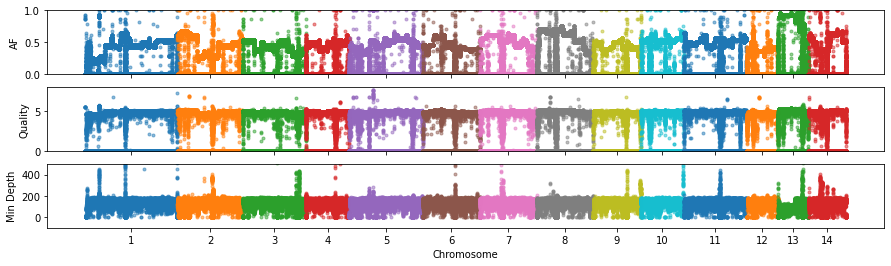

In [41]:
## plot the overal allele freq, quality, and depth
fig,ax = plt.subplots(3,1,figsize=(15,4),sharex=True,sharey='row')
plt.sca(ax[0])
for i,c in enumerate(clens.Contig):
    
    ## gather sliced dataframes
    ## of cum length
    cumsum = clens.T[i+1].T['Cumsum']
    
    ## and gentype df
    temp = GTS[(GTS.Contig==c)]
    
    ## set axis, plot allele freq
    plt.sca(ax[0])
    plt.plot(temp.Pos+cumsum,temp.AF,'.',
             alpha=0.5,rasterized=True);

    ## Set ylimit and lable
    plt.ylim(0,1)
    plt.ylabel('AF' if i == 13 else None)

    ## set axis and plot quality score
    plt.sca(ax[1])
    plt.plot(temp.Pos+cumsum,temp.Qual,'.',
             alpha=0.5,rasterized=True);
    
    ## set ylim and ylabel
    plt.ylim(0,8)
    plt.ylabel('Quality' if i == 13 else None)
    
    ## set axis and plot depth
    plt.sca(ax[2])
    plt.plot(temp.Pos+cumsum,temp.DPmin,'.',
             alpha=0.5,rasterized=True);
    
    ## Set ylim and ylable
    plt.ylim(-100,500);
    plt.ylabel('Min Depth'if i == 13 else None);
    
## set xticks and xlables
plt.xticks(clens.Midpts.values,clens.index.values);
plt.xlabel('Chromosome');

In [15]:
## Set centromere distance
cent_away = 1000

## Find variants near centromeres
## Initilize list
near_centromere_ix=[]

## Iterate thru contigs
for c in clens.Contig:
    
    ## gather chrom 1
    i = int(c.split('_')[-1])-1
    
    ## set centromere
    centro = Centromeres.T[i].values
    
    ## Gather vairants
    temp = GTS[(GTS.Contig==c) & 
               (GTS.Pos>=np.min(centro)-cent_away) & 
               (GTS.Pos<=np.max(centro)+cent_away)]
    
    ## Append indecies
    near_centromere_ix.append(temp.index.tolist())

In [16]:
## Set thresholds for filtering
minaf = 0.05
qual_min = 4
qual_max = 5.4
dpmin = 10
dpmax = 200

In [17]:
## Filter bi-allelic snp sites
GTS_filt_ix = GTS[(GTS.Qual>qual_min) & 
                  (GTS.Qual<qual_max) 
                  & (GTS.DPmin >dpmin) & 
                  (GTS.DPmin<dpmax) & 
                  (GTS.AF>minaf) & 
                  (GTS.AF<1-minaf) &
                  ~(GTS.index.isin(
                      np.concatenate(near_centromere_ix)))
                 ].index.tolist()

## print # of variants
len(GTS_filt_ix)

215411

In [18]:
## Save zipped dataframes with index to vcfs
GTS.T[GTS_filt_ix].T.to_csv('../GENOTYPE/H99_prog_gt.csv.gz',index=True)
DPS.T[GTS_filt_ix].T.to_csv('../GENOTYPE/H99_prog_dps.csv.gz',index=True)
ADPS.T[GTS_filt_ix].T.to_csv('../GENOTYPE/H99_prog_adps.csv.gz',index=True)

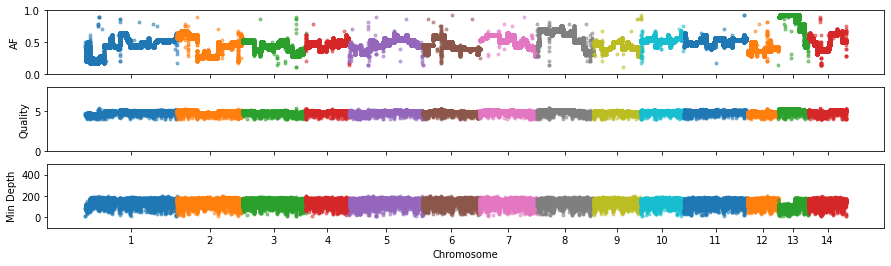

In [40]:
## plot the overal allele freq, quality, and depth
fig,ax = plt.subplots(3,1,figsize=(15,4),sharex=True,sharey='row')
plt.sca(ax[0])
for i,c in enumerate(clens.Contig):
    
    ## gather sliced dataframes
    ## of cum length
    cumsum = clens.T[i+1].T['Cumsum']
    
    ## and gentype df
    temp = GTS[(GTS.Contig==c) & (GTS.index.isin(GTS_filt_ix))]
    
    ## set axis, plot allele freq
    plt.sca(ax[0])
    plt.plot(temp.Pos+cumsum,temp.AF,'.',
             alpha=0.5,rasterized=True);

    ## Set ylimit and lable
    plt.ylim(0,1)
    plt.ylabel('AF' if i == 13 else None)

    ## set axis and plot quality score
    plt.sca(ax[1])
    plt.plot(temp.Pos+cumsum,temp.Qual,'.',
             alpha=0.5,rasterized=True);
    
    ## set ylim and ylabel
    plt.ylim(0,8)
    plt.ylabel('Quality' if i == 13 else None)
    
    ## set axis and plot depth
    plt.sca(ax[2])
    plt.plot(temp.Pos+cumsum,temp.DPmin,'.',
             alpha=0.5,rasterized=True);
    
    ## Set ylim and ylable
    plt.ylim(-100,500);
    plt.ylabel('Min Depth'if i == 13 else None);
    
## set xticks and xlables
plt.xticks(clens.Midpts.values,clens.index.values);
plt.xlabel('Chromosome');

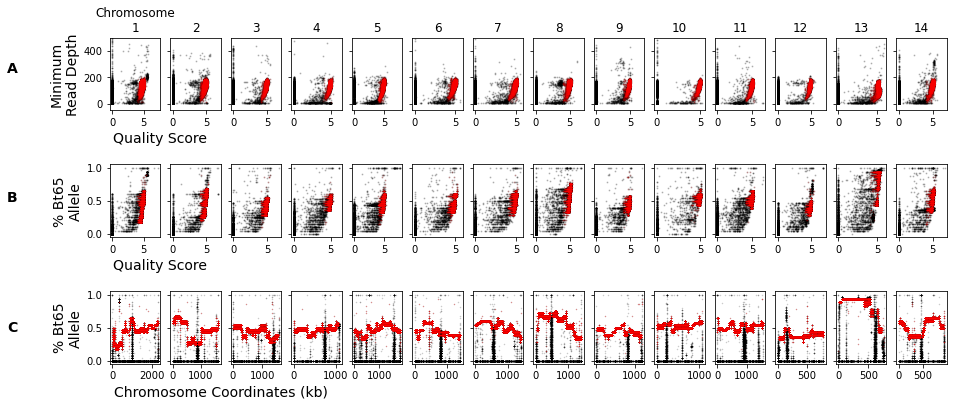

In [36]:
## Call figure
fig,ax = plt.subplots(3,14,figsize=(15,6),sharey='row')

## Itereate over chromosomes
for i,c in enumerate(clens.Contig.values):
    
    ## slices on chromosome
    GTStemp = GTS[(GTS.Contig==c)]
    snptemp = GTS[(GTS.Contig==c) & 
                 (GTS.index.isin(GTS_filt_ix))]
    
    ## Set axis and tilte
    plt.sca(ax[0,i])
    plt.title('Chromosome\n%s'%str(i+1) if i == 0 else str(i+1))
    
    ## plot raw data
    plt.plot(GTStemp.Qual.values,
             GTStemp.DPmin.values,'k.',
             markersize=2,alpha=0.2,rasterized=True)
    
    ## plot filtered snp data
    plt.plot(snptemp.Qual.values,
             snptemp.DPmin.values, 
             'r.',alpha=.1,markersize=2,rasterized=True);
    
    ## Set ylimit, xlabel, and ylabel
    plt.ylim(-50,500)
    plt.xlabel('Quality Score' if i == 0 else None,
               fontsize=14,x=1)
    plt.ylabel('Minimum\nRead Depth' if i == 0 else None,fontsize=14)

    ## Set axis for plotting quality vs allele freq
    plt.sca(ax[1,i])
    
    ## plot raw allele freq
    plt.plot(GTStemp.Qual.values, GTStemp[samples].mean(axis=1),
             'k.',markersize=2,alpha=0.2,rasterized=True)
    
    ## plot filtered snp data
    plt.plot(snptemp.Qual.values, snptemp[samples].mean(axis=1),
             'r.',alpha=.1,markersize=2,rasterized=True);
    
    ## Set x- and ylabel 
    plt.xlabel('Quality Score' if i == 0 else None,
               fontsize=14,x=1)
    plt.ylabel('% Bt65\nAllele' if i == 0 else None,fontsize=14)

    ## Set axis for ploting allele freq by position
    plt.sca(ax[2,i])
    
    ## plot raw allele freq vs chrom pos
    plt.plot(GTStemp.Pos.values/1000, GTStemp[samples].mean(axis=1),
             'k.', markersize=1,alpha=0.2,rasterized=True)
    
    ## plot filtered snp data
    plt.plot(snptemp.Pos.values/1000,snptemp[samples].mean(axis=1),
             'r.',markersize=0.5,alpha=0.5,rasterized=True)
    
    ## Set x- and ylabel
    plt.xlabel('Chromosome Coordinates (kb)' if i == 0 else None,
               fontsize=14, x=2.2)
    plt.ylabel('% Bt65\nAllele' if i == 0 else None,fontsize=14)

## Addjust plot
plt.subplots_adjust(hspace=0.75)

## Set axis
plt.sca(ax[2,0]);

## plot fig section lables
## Make inverted list of lables 
fig_label = ['A','B','C'][::-1]

## Iterate thru and plot
for i,y in enumerate([0.2,0.5,0.8]):
    fig.text(x=0.03,y=y,s=fig_label[i],
             fontweight='bold',fontsize=14)

## Save figure
plt.savefig('../FIGURES/Figure_S14.pdf',dpi=300,bbox_inches='tight')

In [56]:
## Take short names
short_names = [str(int(samp.split('_')[0].split('prog')[-1])) 
               for samp in samples]

## Gather col names
cols = GTS.columns.tolist()

## makenew col names
newcols = short_names+cols[cols.index('Pos'):]

## check work
assert len(cols) == len(newcols), "Column renaming mismatch error"

## Set new column names
GTS.columns = newcols

## Gather snps
SNP = GTS.loc[GTS_filt_ix,:]

## Save dataframe
SNP.to_csv('../GENOTYPE/Bt65xH99_F1_progeny-SNPS.csv.gz')

## View head
SNP.head().T.head()

,191,192,339,341,377
41,1,1,0,0,0
17,1,1,1,1,0
36,0,0,0,0,0
14,1,1,1,1,1
12,1,1,1,1,0
